# Cyclistic Bike-share Analysis Case Study
#### Michael Lee
#### 06/08/2025

## Scenario
You are a junior data analyst working on the marketing analyst team at Cyclistic, a bike-share company in Chicago. The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, your team wants to understand how casual riders and annual members use Cyclistic bikes differently. From these insights, your team will design a new marketing strategy to convert casual riders into annual members. But first, Cyclistic executives must approve your recommendations, so they must be backed up with compelling data insights and professional data visualizations.

## 01. ASK - Identify business task
**Guiding question**: How do we convert casual riders into annual members?

**Business task**: Analyze how casual riders and annual members use Cyclistic bikes differently to support a marketing strategy that converts casual riders into annual members.

**Key stakeholders**: Lily Moreno (Director of marketing), Cyclistic executives, marketing analytics team, customers

## 02. PREPARE - Load the datasets and verify data integrity

In [1]:
# Import necessary packages
import pandas as pd
import zipfile
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import folium
from folium.plugins import MarkerCluster

Instead of manually unzipping and modifying each file, opting to access the data in its zipped format offers a more efficient process. Not only is it quicker, it also avoids any risks of data loss when unzipping and saving in different formats.

In [2]:
# Path to folder with downloaded Divvy data zip files
zip_folder = '../Datasets/zip_files/'
    
# Get all zip files in the folder
zip_files = [f for f in os.listdir(zip_folder) if f.endswith('.zip')]
# To store dataframes
df_dict = {}

# Loop through each zip file and load the CSVs
for zip_file in zip_files:
    zip_path = os.path.join(zip_folder, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as z:
        for filename in z.namelist():
            if filename.endswith('.csv') and not filename.startswith('__MACOSX/'):
                df = pd.read_csv(z.open(filename))
                # Extract the YYMM from the filename for key
                base_name = os.path.splitext(zip_file)[0] 
                yyyymm = base_name.split('-')[0] 
                key = f"df_{yyyymm[2:]}"
                df_dict[key] = df
                break

print(df_dict.keys()) # List each key (dataset) in the dictionary

dict_keys(['df_2405', 'df_2406', 'df_2407', 'df_2408', 'df_2409', 'df_2410', 'df_2411', 'df_2412', 'df_2501', 'df_2502', 'df_2503', 'df_2504'])


A quick look at one of the datasets:

In [3]:
df_dict['df_2405'].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7D9F0CE9EC2A1297,classic_bike,2024-05-25 15:52:42,2024-05-25 16:11:50,Streeter Dr & Grand Ave,13022,Clark St & Elm St,TA1307000039,41.892278,-87.612043,41.902973,-87.631280,casual
1,02EC47687411416F,classic_bike,2024-05-14 15:11:51,2024-05-14 15:22:00,Sheridan Rd & Greenleaf Ave,KA1504000159,Sheridan Rd & Loyola Ave,RP-009,42.010587,-87.662412,42.001044,-87.661198,casual
2,101370FB2D3402BE,classic_bike,2024-05-30 17:46:04,2024-05-30 18:09:16,Streeter Dr & Grand Ave,13022,Wabash Ave & 9th St,TA1309000010,41.892278,-87.612043,41.870769,-87.625734,member
3,E97E396331ED6913,electric_bike,2024-05-17 20:21:54,2024-05-17 20:40:32,Streeter Dr & Grand Ave,13022,Sheffield Ave & Wellington Ave,TA1307000052,41.892270,-87.611946,41.936253,-87.652662,member
4,674EDE311C543165,classic_bike,2024-05-22 18:52:20,2024-05-22 18:59:04,Larrabee St & Division St,KA1504000079,Clark St & Elm St,TA1307000039,41.903486,-87.643353,41.902973,-87.631280,casual


## 03. PROCESS - Clean and modify each dataframe to prep for analysis

In [4]:
for key, df in df_dict.items(): # Loop through each df to clean and add columns
    # Convert to datetime format, if not already
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Add ride_length column to calculate the length of each trip
    df['ride_length'] = df['ended_at'] - df['started_at']
    
    # Add day_of_week column (Sunday = 1 to Saturday = 7)
    # Default is Monday = 0 to Sunday = 6, so we need to adjust
    df['day_of_week'] = (df['started_at'].dt.dayofweek + 1) % 7 + 1 
    
    print(f"\n--- {key} ---")
    # Missing values per column
    print("Missing values:")
    null_sum = df.isnull().sum()
    if null_sum.sum() > 0:
        print(null_sum[null_sum > 0])
   
    # Rows with missing values
    rows_missing = df.isnull().any(axis=1).sum()
    print(f"Rows with missing values: {rows_missing / len(df) * 100:.2f}%")

    # Number of duplicate rows
    duplicate_count = df.duplicated().sum()
    print(f"Duplicate rows: {duplicate_count}")


--- df_2405 ---
Missing values:
start_station_name    109048
start_station_id      109048
end_station_name      112731
end_station_id        112731
end_lat                  784
end_lng                  784
dtype: int64
Rows with missing values: 27.45%
Duplicate rows: 0

--- df_2406 ---
Missing values:
start_station_name    144025
start_station_id      144025
end_station_name      148027
end_station_id        148027
end_lat                 1124
end_lng                 1124
dtype: int64
Rows with missing values: 30.45%
Duplicate rows: 0

--- df_2407 ---
Missing values:
start_station_name    136965
start_station_id      136965
end_station_name      139224
end_station_id        139224
end_lat                 1091
end_lng                 1091
dtype: int64
Rows with missing values: 27.78%
Duplicate rows: 0

--- df_2408 ---
Missing values:
start_station_name    140591
start_station_id      140591
end_station_name      142225
end_station_id        142225
end_lat                 1027
end_lng  

All datasets contain values for the `started_at` and `ended_at` columns, which ensures that our calculated time-based columns (e.g., ride duration, day of week) will be complete for every entry.

However, many missing values are found in the station name and location columns. While we can still include station and geographic analysis, it’s important to acknowledge the limitations and potential inaccuracies this missing data introduces when evaluating station-level or location-based trends.

Another look at the same dataset after modifying:

In [5]:
df_dict['df_2405'].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,7D9F0CE9EC2A1297,classic_bike,2024-05-25 15:52:42,2024-05-25 16:11:50,Streeter Dr & Grand Ave,13022,Clark St & Elm St,TA1307000039,41.892278,-87.612043,41.902973,-87.631280,casual,0 days 00:19:08,7
1,02EC47687411416F,classic_bike,2024-05-14 15:11:51,2024-05-14 15:22:00,Sheridan Rd & Greenleaf Ave,KA1504000159,Sheridan Rd & Loyola Ave,RP-009,42.010587,-87.662412,42.001044,-87.661198,casual,0 days 00:10:09,3
2,101370FB2D3402BE,classic_bike,2024-05-30 17:46:04,2024-05-30 18:09:16,Streeter Dr & Grand Ave,13022,Wabash Ave & 9th St,TA1309000010,41.892278,-87.612043,41.870769,-87.625734,member,0 days 00:23:12,5
3,E97E396331ED6913,electric_bike,2024-05-17 20:21:54,2024-05-17 20:40:32,Streeter Dr & Grand Ave,13022,Sheffield Ave & Wellington Ave,TA1307000052,41.892270,-87.611946,41.936253,-87.652662,member,0 days 00:18:38,6
4,674EDE311C543165,classic_bike,2024-05-22 18:52:20,2024-05-22 18:59:04,Larrabee St & Division St,KA1504000079,Clark St & Elm St,TA1307000039,41.903486,-87.643353,41.902973,-87.631280,casual,0 days 00:06:44,4


We added two new columns to our dataframe:  
- `ride_length` – Calculates the duration of each bike trip  
- `day_of_week` – Identifies which day of the week the trip occurred

In [6]:
# Merge the processed dataframes into one
combined_df = pd.concat(df_dict.values(), ignore_index=True)

print('Columns and datatypes in combined_df:')
print(combined_df.info())

Columns and datatypes in combined_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735884 entries, 0 to 5735883
Data columns (total 15 columns):
 #   Column              Dtype          
---  ------              -----          
 0   ride_id             object         
 1   rideable_type       object         
 2   started_at          datetime64[ns] 
 3   ended_at            datetime64[ns] 
 4   start_station_name  object         
 5   start_station_id    object         
 6   end_station_name    object         
 7   end_station_id      object         
 8   start_lat           float64        
 9   start_lng           float64        
 10  end_lat             float64        
 11  end_lng             float64        
 12  member_casual       object         
 13  ride_length         timedelta64[ns]
 14  day_of_week         int32          
dtypes: datetime64[ns](2), float64(4), int32(1), object(7), timedelta64[ns](1)
memory usage: 634.5+ MB
None


In [7]:
print(combined_df['ride_length'].describe())

count                      5735884
mean     0 days 00:16:53.380948522
std      0 days 00:58:33.459480860
min              -2 days +02:11:41
25%         0 days 00:05:29.242000
50%         0 days 00:09:37.130500
75%         0 days 00:17:03.511250
max         1 days 01:59:55.072000
Name: ride_length, dtype: object


The shortest recorded trip duration is around **-2 days**, which is not possible. This likely resulted from a data entry error or system malfunction. To ensure data accuracy, we will remove this entry from our analysis and check for additional outliers.

In [8]:
# Trips < 60s
short_rides = combined_df[combined_df['ride_length'].dt.total_seconds() < 60]
print(f"Number of rides shorter than 60 seconds: {len(short_rides)}")

Number of rides shorter than 60 seconds: 126460


In [9]:
print(f'Rows in combined_df: {len(combined_df)}')
# Filter entries where ride_length < 60s
filtered_df = combined_df[combined_df['ride_length'].dt.total_seconds() >= 60].copy()
row_count_filtered = len(filtered_df)
print(f'Rows in filtered_df: {row_count_filtered}')
count_removed_rows = len(combined_df) - row_count_filtered
percent_rows = round(count_removed_rows / len(combined_df) * 100, 2)
print(f'Percent of rows removed: {percent_rows}%')

# 99th percentile ride duration in minutes
filtered_df['ride_length_minutes'] = filtered_df['ride_length'].dt.total_seconds() / 60 # Convert to minutes
max_cutoff = filtered_df['ride_length_minutes'].quantile(0.99)
print(f"99th percentile cutoff: {max_cutoff:.2f} minutes")
# Filter out top 1%
filtered_df = filtered_df[filtered_df['ride_length_minutes'] <= max_cutoff]
row_count_filtered = len(filtered_df)
print(f'Rows in filtered_df after removing top 1%: {row_count_filtered}')

Rows in combined_df: 5735884
Rows in filtered_df: 5609424
Percent of rows removed: 2.2%
99th percentile cutoff: 99.80 minutes
Rows in filtered_df after removing top 1%: 5553329


As stated by Lyft:
    
    "The data has been processed to remove trips that are taken by staff as they service and inspect the system; and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure)."

However, some records with ride durations under 60 seconds are still present in the datasets, suggesting they may have been overlooked. To ensure data quality and consistency, we removed these trips, which resulted in a reduction of approximately **2.2%** of total rows.

Additionally, we removed the top 1% of rides (for a total of 3.2%) with unusually long durations to ensure the accuracy of our analysis, which included any rides longer than **99.80 minutes**. These extreme outliers may be the result of errors such as bikes not being properly docked or trips that were not correctly ended. Including them could skew our average ride length and other time-based metrics.

By filtering out these outliers, we retain 96.8% of the data, which gives us a more reliable representation of typical rider behavior. Now that our data has been properly cleaned and processed, we can begin the analysis phase.

## 04. ANALYZE - Explore data, perform calculations, identify trends
## 05. SHARE - Create supporting visualizations to share findings
  
**Consider**: How do members vs. casual riders use the bikes differently?

In [10]:
print(filtered_df['ride_length'].describe())

count                      5553329
mean     0 days 00:13:47.560859657
std      0 days 00:12:57.401492464
min                0 days 00:01:00
25%         0 days 00:05:41.427000
50%         0 days 00:09:44.630000
75%         0 days 00:16:58.350000
max         0 days 01:39:47.682000
Name: ride_length, dtype: object


A quick overview of the data gives us a general understanding of its structure, but to address the business question, we need to focus on how casual riders and members differ in their behavior.

In [11]:
# Group by summary stats
print(filtered_df.groupby('member_casual')['ride_length'].describe())

                 count                       mean                        std  \
member_casual                                                                  
casual         2000349  0 days 00:17:35.836855773  0 days 00:16:29.741577172   
member         3552980  0 days 00:11:39.040107906  0 days 00:09:49.268846325   

                           min                     25%  \
member_casual                                            
casual         0 days 00:01:00  0 days 00:06:55.607000   
member         0 days 00:01:00  0 days 00:05:11.356750   

                                  50%                     75%  \
member_casual                                                   
casual         0 days 00:12:01.834000  0 days 00:21:49.834000   
member         0 days 00:08:44.040000  0 days 00:14:43.630250   

                                  max  
member_casual                          
casual         0 days 01:39:47.682000  
member         0 days 01:39:47.629000  


This summary provides insights into how ride lengths differ between casual riders and members:

- The majority of rides are taken by **members**
- **Casual riders** tend to take longer trips than **members** on average (~17.5 minutes vs ~11.5 minutes)
- **Members** show more consistent ride durations, indicated by a lower standard deviation and a tighter range between the 25th and 75th percentiles
- The maximum ride duration for both groups is now under 1 hour 40 minutes for both groups, which is much more realistic than before filtering

We can split the dataframe into two different sets for members and casual riders for further exploration.

In [12]:
member_df = filtered_df[filtered_df['member_casual'] == 'member'].copy() # Filter for members
casual_df = filtered_df[filtered_df['member_casual'] == 'casual'].copy() # Filter for casual riders

### Members vs. Casual Riders Trends

#### Month Counts

In [13]:
member_df['start_month'] = member_df['started_at'].dt.month
member_month_counts = member_df['start_month'].value_counts()
print(f'Most active months for members:\n{member_month_counts}')

Most active months for members:
start_month
9     464668
8     429133
7     420754
6     400971
10    393886
5     369060
4     257395
11    238250
3     207937
12    137143
2     121789
1     111994
Name: count, dtype: int64


In [14]:
casual_df['start_month'] = casual_df['started_at'].dt.month
casual_month_counts = casual_df['start_month'].value_counts()
print(f'Most active months for casual riders:\n{casual_month_counts}')

Most active months for casual riders:
start_month
9     328793
7     301629
8     300655
6     282969
5     217359
10    206369
4     103798
11     89594
3      82039
12     37088
2      26827
1      23229
Name: count, dtype: int64


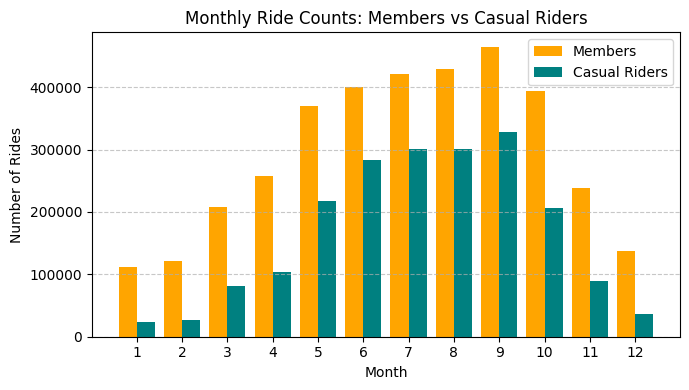

In [15]:
# Sort months in order
member_month_counts = member_month_counts.sort_index()
casual_month_counts = casual_month_counts.sort_index()

months = np.array(range(1, 13))
bar_width = 0.4
# Plot
plt.figure(figsize=(7, 4))
plt.bar(months - bar_width/2, member_month_counts.values, width=bar_width, label='Members', color='orange')
plt.bar(months + bar_width/2, casual_month_counts.values, width=bar_width, label='Casual Riders', color='teal')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Monthly Ride Counts: Members vs Casual Riders')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The monthly ride distribution follows a similar pattern for both groups, with peaks in the summer and fall and fewer rides during the winter months. This trend is likely a result of seasonal changes in weather and riding conditions.

It's important to note that members have a higher total ride count across all months because members make up more than 60% of the data. To meaningfully compare behaviors between groups, we need to use a normalized version of the chart that accounts for differences in group sizes and highlights relative trends.

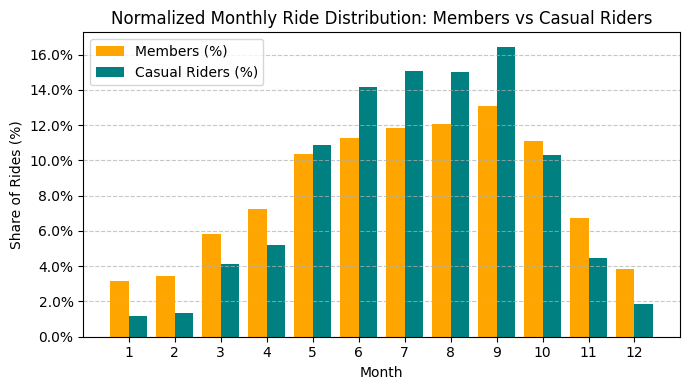

In [16]:
# Sort months in order
member_month_counts = member_month_counts.sort_index()
casual_month_counts = casual_month_counts.sort_index()
# Normalize monthly counts
member_month_pct = member_month_counts / member_month_counts.sum()
casual_month_pct = casual_month_counts / casual_month_counts.sum()

months = np.array(range(1, 13))
bar_width = 0.4
# Plot
plt.figure(figsize=(7, 4))
plt.bar(months - bar_width/2, member_month_pct.values, width=bar_width, label='Members (%)', color='orange')
plt.bar(months + bar_width/2, casual_month_pct.values, width=bar_width, label='Casual Riders (%)', color='teal')
plt.xlabel('Month')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Monthly Ride Distribution: Members vs Casual Riders')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

In this normalized version, casual riders show a higher proportion of their annual rides occurring in the summer and fall compared to members. In contrast, members have a higher proportion during the winter. This suggests a more **need-basis for members, even during months with poor weather conditions**, whereas **casual riders are more likely to ride during favorable weather**.

#### Day Counts

In [17]:
member_day_counts = member_df['day_of_week'].value_counts()
print(f'Most popular days for members:\n{member_day_counts}')

Most popular days for members:
day_of_week
4    583527
5    548434
3    540356
6    520859
2    506735
7    459285
1    393784
Name: count, dtype: int64


**Members** prefer to use bikes during the week with **Wednesdays** having the highest count.

In [18]:
casual_day_counts = casual_df['day_of_week'].value_counts()
print(f'Most popular days for casual riders:\n{casual_day_counts}')

Most popular days for casual riders:
day_of_week
7    408059
1    332553
6    308515
4    253992
5    250741
2    232345
3    214144
Name: count, dtype: int64


**Casual riders** typically ride on weekends with **Saturdays** having the highest count.

Like with the months, we will consider the normalized distribution of daily rides to better compare ride patterns.

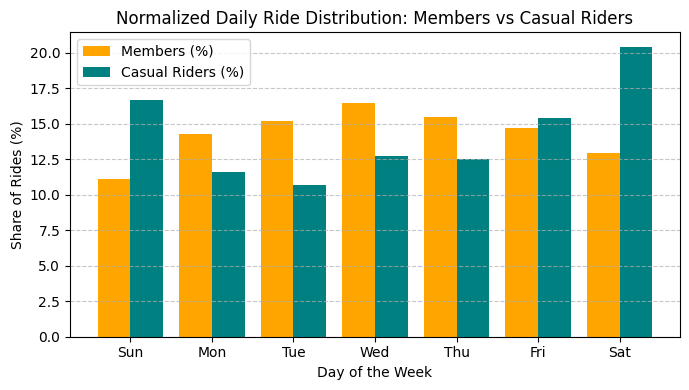

In [19]:
# Sort day counts by day index (1=Sun to 7=Sat)
member_day_counts = member_day_counts.sort_index()
casual_day_counts = casual_day_counts.sort_index()

# Normalize to get share of weekly rides
member_day_pct = (member_day_counts / member_day_counts.sum()) * 100
casual_day_pct = (casual_day_counts / casual_day_counts.sum()) * 100

# X-axis positions
days = np.array(range(1, 8))
bar_width = 0.4

# Plot
plt.figure(figsize=(7, 4))
plt.bar(days - bar_width/2, member_day_pct.values, width=bar_width, label='Members (%)', color='orange')
plt.bar(days + bar_width/2, casual_day_pct.values, width=bar_width, label='Casual Riders (%)', color='teal')

# Labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Daily Ride Distribution: Members vs Casual Riders')
plt.xticks(days, ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

**Members** tend to ride more consistently throughout the workweek, peaking mid-week on Wednesdays. In contrast, **casual riders** show a strong preference for weekends, with Saturdays accounting for over 20% of their weekly rides. This pattern reinforces the idea that casual users likely ride for leisure, while members use the service more for commuting or routine travel.

#### Hour Counts

In [20]:
# Calculate most active hours for both groups
member_df['start_hour'] = member_df['started_at'].dt.hour
member_hour_counts = member_df['start_hour'].value_counts()
print(f'Most common start times for members:\n{member_hour_counts}')

Most common start times for members:
start_hour
17    376397
16    329912
18    294681
8     247669
15    240041
19    206796
12    194695
7     193775
14    193642
13    193240
11    170803
9     168301
10    146619
20    144072
21    111000
6      99420
22     80421
23     50377
5      33539
0      31263
1      19263
2      11034
4       8334
3       7686
Name: count, dtype: int64


In [21]:
casual_df['start_hour'] = casual_df['started_at'].dt.hour
casual_hour_counts = casual_df['start_hour'].value_counts()
print(f'Most common start times for casual riders:\n{casual_hour_counts}')

Most common start times for casual riders:
start_hour
17    191170
16    177671
18    163888
15    156598
14    141079
13    134731
12    129586
19    120284
11    109996
20     88209
10     86023
21     73498
8      72325
9      71303
22     64211
7      51266
23     44869
0      33567
6      27788
1      22427
2      14144
5      11490
3       7884
4       6342
Name: count, dtype: int64


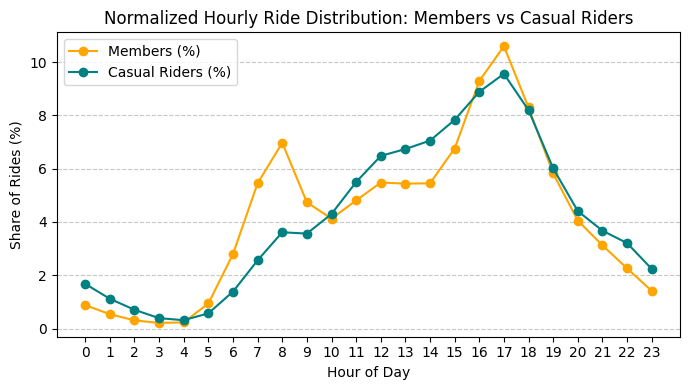

In [22]:
member_hour_counts = member_hour_counts.sort_index()
casual_hour_counts = casual_hour_counts.sort_index()

# Normalize to percent of total rides per group
member_hour_pct = (member_hour_counts / member_hour_counts.sum()) * 100
casual_hour_pct = (casual_hour_counts / casual_hour_counts.sum()) * 100

# Plot
plt.figure(figsize=(7, 4))
plt.plot(member_hour_pct.index, member_hour_pct.values, marker='o', label='Members (%)', color='orange')
plt.plot(casual_hour_pct.index, casual_hour_pct.values, marker='o', label='Casual Riders (%)', color='teal')

plt.xlabel('Hour of Day')
plt.ylabel('Share of Rides (%)')
plt.title('Normalized Hourly Ride Distribution: Members vs Casual Riders')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Both groups prefer to ride at similar hours. We see a peak in afternoon times around 5 PM for both members and casual riders. However, one distinction is that there is another peak in the morning around 8 AM as well for members, while the proportion of rides for casual riders is lower.

By analyzing the data by month, day of week, and hour of day, the data suggests that **members are more likely using the bikes for commuting purposes** whereas **casual riders exhibit patterns indicating leisure-based usage**.

#### Ride Types

In [23]:
# Calculate most popular ride type for both groups
member_ridetype_counts = member_df['rideable_type'].value_counts()
print(f'Most popular ride types for members:\n{member_ridetype_counts}')

Most popular ride types for members:
rideable_type
electric_bike       1894857
classic_bike        1601998
electric_scooter      56125
Name: count, dtype: int64


In [24]:
casual_ridetype_counts = casual_df['rideable_type'].value_counts()
print(f'Most popular ride types for casual riders:\n{casual_ridetype_counts}')

Most popular ride types for casual riders:
rideable_type
electric_bike       1037157
classic_bike         881988
electric_scooter      81204
Name: count, dtype: int64


**Electric bikes** were most popular amongst both groups most likely for their speed and ease of use.

#### Popular Starting and Ending Stations
**Disclaimer:** The datasets are missing approximately 25-35% of data related to stations and coordinates. Therefore, the analysis may not fully represent all rides taken within the past year.

In [25]:
# Calculate most popular start stations for both groups
member_start_station_counts = member_df['start_station_name'].value_counts().head()
print(f'Top 5 starting stations for members:\n{member_start_station_counts}')

member_end_station_counts = member_df['end_station_name'].value_counts().head()
print(f'\nTop 5 ending stations for members:\n{member_end_station_counts}')

Top 5 starting stations for members:
start_station_name
Kingsbury St & Kinzie St        30505
Clinton St & Washington Blvd    26085
Clark St & Elm St               24104
Clinton St & Madison St         23765
Canal St & Madison St           20350
Name: count, dtype: int64

Top 5 ending stations for members:
end_station_name
Kingsbury St & Kinzie St        30971
Clinton St & Washington Blvd    26643
Clinton St & Madison St         24988
Clark St & Elm St               24049
Canal St & Madison St           20695
Name: count, dtype: int64


In [26]:
casual_start_station_counts = casual_df['start_station_name'].value_counts().head()
print(f'Top 5 starting stations for casual riders:\n{casual_start_station_counts}')

casual_end_station_counts = casual_df['end_station_name'].value_counts().head()
print(f'\nTop 5 ending stations for casual riders:\n{casual_end_station_counts}')

Top 5 starting stations for casual riders:
start_station_name
Streeter Dr & Grand Ave               46645
DuSable Lake Shore Dr & Monroe St     31257
Michigan Ave & Oak St                 23108
DuSable Lake Shore Dr & North Blvd    21606
Millennium Park                       20624
Name: count, dtype: int64

Top 5 ending stations for casual riders:
end_station_name
Streeter Dr & Grand Ave               50410
DuSable Lake Shore Dr & Monroe St     29224
DuSable Lake Shore Dr & North Blvd    25232
Michigan Ave & Oak St                 23837
Millennium Park                       22381
Name: count, dtype: int64


The top 5 starting and ending stations for each rider group reveal differing travel behaviors.
The most frequented stations for members and casual riders do not overlap, indicating that **each group tends to favor different parts of the city**.

**Map of Top 10 Start Stations for Each Rider Group**

In [ ]:
# Get top 10 start stations for each user type
top_member_stations = member_df['start_station_name'].value_counts().head(10).index
top_casual_stations = casual_df['start_station_name'].value_counts().head(10).index

# Filter to those stations
member_stations_df = member_df[member_df['start_station_name'].isin(top_member_stations)]
casual_stations_df = casual_df[casual_df['start_station_name'].isin(top_casual_stations)]

# Drop duplicates to avoid plotting the same station multiple times
member_stations_df = member_stations_df.drop_duplicates(subset=['start_station_name'])
casual_stations_df = casual_stations_df.drop_duplicates(subset=['start_station_name'])

lat_col = 'start_lat'
lng_col = 'start_lng'
# Center map around average location
avg_lat = filtered_df[lat_col].mean()
avg_lng = filtered_df[lng_col].mean()
m = folium.Map(location=[avg_lat, avg_lng], zoom_start=13)

# Add member station markers
for _, row in member_stations_df.iterrows():
    folium.Marker(
        location=[row[lat_col], row[lng_col]],
        popup=f"Member Station: {row['start_station_name']}",
        icon=folium.Icon(color='orange', icon='bicycle', prefix='fa')
    ).add_to(m)

# Add casual station markers
for _, row in casual_stations_df.iterrows():
    folium.Marker(
        location=[row[lat_col], row[lng_col]],
        popup=f"Casual Station: {row['start_station_name']}",
        icon=folium.Icon(color='darkblue', icon='bicycle', prefix='fa')
    ).add_to(m)
m # Show map

In [ ]:
m.save('map_top_10_stations.html') # Save map for display purposes

[Click here to view the interactive map](map_top_10_stations.html)

Static screenshot of the map for issues with displaying interactive `Folium` map in environments like GitHub:

![Map Screenshot](map_top_10_stations.png)

This interactive map displays the top 10 start stations for each rider group and offers a spatial perspective on rider behavior.

- **Members** frequently use stations located in Chicago’s downtown business district, such as those near Union Station and the Loop (e.g., *Kingsbury St & Kinzie St*, *Clinton St & Washington Blvd*, *Clark St & Elm St*). This suggests that members likely use the service for commuting or daily routines.
  
- **Casual riders**, however, mostly start and end rides near waterfronts and popular tourist destinations like Navy Pier, Millennium Park, and the Lakefront Trail (e.g., *Streeter Dr & Grand Ave*, *DuSable Lake Shore Dr & Monroe St*). This points to more recreational or sightseeing use.

Popular member stations concentrate around business centers, while stations most used by casual riders align with Chicago’s scenic and tourist-friendly areas. This geographic divide reinforces the idea that members are likely locals using bikes for transportation, while casual riders are more often tourists or infrequent users.

In [27]:
member_start_pct = round(member_start_station_counts / member_df.shape[0] * 100, 2)
print(f'Normalized top 5 starting stations for members:\n{member_start_pct}')

member_end_pct = round(member_end_station_counts / member_df.shape[0] * 100, 2)
print(f'\nNormalized top 5 ending stations for members:\n{member_end_pct}')

Normalized top 5 starting stations for members:
start_station_name
Kingsbury St & Kinzie St        0.86
Clinton St & Washington Blvd    0.73
Clark St & Elm St               0.68
Clinton St & Madison St         0.67
Canal St & Madison St           0.57
Name: count, dtype: float64

Normalized top 5 ending stations for members:
end_station_name
Kingsbury St & Kinzie St        0.87
Clinton St & Washington Blvd    0.75
Clinton St & Madison St         0.70
Clark St & Elm St               0.68
Canal St & Madison St           0.58
Name: count, dtype: float64


In [28]:
casual_start_pct = round(casual_start_station_counts / casual_df.shape[0] * 100, 2)
print(f'Normalized top 5 starting stations for casual riders:\n{casual_start_pct}')

casual_end_pct = round(casual_end_station_counts / casual_df.shape[0] * 100, 2)
print(f'\nNormalized top 5 ending stations for casual riders:\n{casual_end_pct}')

Normalized top 5 starting stations for casual riders:
start_station_name
Streeter Dr & Grand Ave               2.33
DuSable Lake Shore Dr & Monroe St     1.56
Michigan Ave & Oak St                 1.16
DuSable Lake Shore Dr & North Blvd    1.08
Millennium Park                       1.03
Name: count, dtype: float64

Normalized top 5 ending stations for casual riders:
end_station_name
Streeter Dr & Grand Ave               2.52
DuSable Lake Shore Dr & Monroe St     1.46
DuSable Lake Shore Dr & North Blvd    1.26
Michigan Ave & Oak St                 1.19
Millennium Park                       1.12
Name: count, dtype: float64


Comparing the percentage of rides from the top 5 starting and ending stations for each group shows another key difference:

-  For **casual riders**, 2.33% of rides start at their most popular station and 2.52% end there
- For **members**, only 0.86% of rides start at their most popular station and 0.87% end there

These statistics support that casual riders tend to concentrate their trips around a few iconic, tourist-heavy locations, while member rides are more evenly distributed across the area. Even though the percentages may seem small, they represent tens of thousands of trips and reveal important differences in how the service is used by each group.

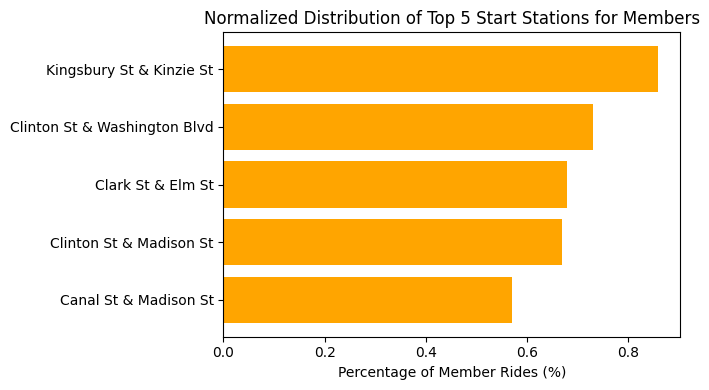

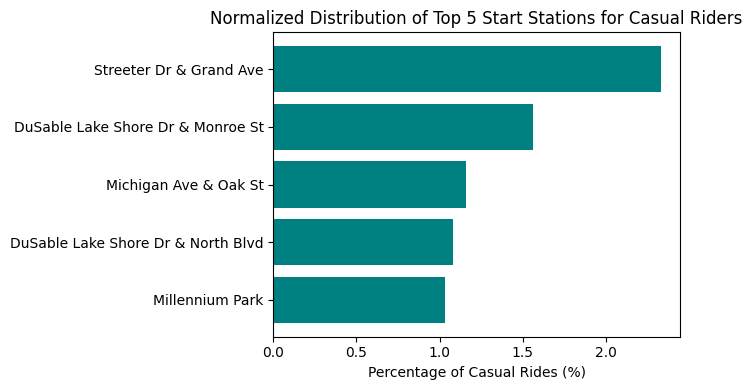

In [29]:
member_start_pct = member_start_pct.sort_values()
# Plot for members
plt.figure(figsize=(7, 4))
plt.barh(member_start_pct.index, member_start_pct.values, color='orange')
plt.xlabel('Percentage of Member Rides (%)')
plt.title('Normalized Distribution of Top 5 Start Stations for Members')
plt.tight_layout()
plt.show()

casual_start_pct = casual_start_pct.sort_values()
# Plot for casual riders
plt.figure(figsize=(7, 4))
plt.barh(casual_start_pct.index, casual_start_pct.values, color='teal')
plt.xlabel('Percentage of Casual Rides (%)')
plt.title('Normalized Distribution of Top 5 Start Stations for Casual Riders')
plt.tight_layout()
plt.show()

The charts illustrate that members tend to have a more even distribution of rides across a wide range of stations, whereas casual riders concentrate their trips more heavily at just a few popular stations.
- For members, the difference between the first and second most popular start stations is 0.13%
- For casual riders, the difference between the first and second most popular start stations is 0.77%

This larger gap for casual riders reflects a strong preference for select stations, while members’ smaller gap indicates a more diverse usage pattern.

#### Popular Routes

Instead of looking at starting and ending stations separately, we can also consider the two together to get a sense of popular routes taken by each group.

In [30]:
member_routes = member_df.groupby(['start_station_name', 'end_station_name']).size().sort_values(ascending=False).head()
print(f'Top 5 routes for members:\n{member_routes}')

Top 5 routes for members:
start_station_name     end_station_name        
State St & 33rd St     Calumet Ave & 33rd St       4836
Calumet Ave & 33rd St  State St & 33rd St          4814
Ellis Ave & 60th St    Ellis Ave & 55th St         4022
Ellis Ave & 55th St    Ellis Ave & 60th St         3781
Ellis Ave & 60th St    University Ave & 57th St    3704
dtype: int64


In [31]:
casual_routes = casual_df.groupby(['start_station_name', 'end_station_name']).size().sort_values(ascending=False).head()
print(f'Top 5 routes for casual riders:\n{casual_routes}')

Top 5 routes for casual riders:
start_station_name                 end_station_name                 
Streeter Dr & Grand Ave            Streeter Dr & Grand Ave              7506
DuSable Lake Shore Dr & Monroe St  DuSable Lake Shore Dr & Monroe St    6255
                                   Streeter Dr & Grand Ave              4936
Michigan Ave & Oak St              Michigan Ave & Oak St                3972
Dusable Harbor                     Dusable Harbor                       2762
dtype: int64


In [32]:
# Create a boolean column for each group to indicate trips that started and ended at same station
member_df['same_station'] = member_df['start_station_name'] == member_df['end_station_name']
casual_df['same_station'] = casual_df['start_station_name'] == casual_df['end_station_name']

member_same_station_pct = member_df['same_station'].mean()
casual_same_station_pct = casual_df['same_station'].mean()

print(f"Percentage of member rides that start/end at the same station: {member_same_station_pct:.2%}")
print(f"Percentage of casual rides that start/end at the same station: {casual_same_station_pct:.2%}")

Percentage of member rides that start/end at the same station: 1.66%
Percentage of casual rides that start/end at the same station: 5.68%


The most common routes for members and casual riders further emphasize the difference in how each group uses the bike-sharing system.

- **Members** tend to ride between different stations (*State St & 33rd St → Calumet Ave & 33rd St*)
- 1.66% of trips started and ended at the same station for members

  These are point-to-point trips often located near universities and residential areas, likely for commuting, classes, or other daily activities.

- **Casual riders** commonly take loop rides (*Streeter Dr & Grand Ave → Streeter Dr & Grand Ave*)
- 5.68% of trips started and ended at the same station for casual riders

  These routes start and end at the same location, indicating leisure or recreational use, often around popular tourist destinations near the lakefront.

This route data further reinforces the broader trend in which members use the bikes as a transportation tool, while casual riders treat it more as a recreational experience.

## 06. ACT - Provide recommendations based on findings
This analysis reveals several key insights into how casual riders and members use Cyclistic bikes differently:

- **Casual riders are more likely to use Cyclistic bikes for leisure.**

- **Members tend to use the service for commuting.**

**Trends by month, day, and hour**:
    Casual riders show strong seasonal and weekly trends, with ride counts peaking during summer and fall months and weekends, especially Saturdays. Members exhibit more consistent usage throughout the year and across weekdays, reflecting commuting behavior. Hourly analysis further confirms that members tend to ride during typical commute times (morning and evening peaks), whereas casual riders favor midday and afternoon hours.

**Station and location usage**:
Casual riders mainly start and end rides near scenic and recreational locations, while members prefer stations near business districts and transit hubs, supporting their daily travel needs. Analyzing the most frequented routes further supports this distinction, indicating that casual riders favor leisure-focused loops and members use more direct, point-to-point routes between home, work, and transit.

| Aspect | Casual Riders | Members |
|--------|---------------|---------|
| Usage Purpose | More likely to use Cyclistic bikes for leisure. | Tend to use the service for commuting. |
| Monthly Trend | Show strong seasonal trends with rides peaking in summer and fall. | Rides also peak in summer and fall, but have somewhat more of a consistent usage year-round. |
| Daily Trend | Rides peak on weekends, especially Saturdays. | Rides peak on weekdays, mostly on Wednesdays. |
| Hourly Trend | Favor midday and afternoon rides. | Ride during typical commute times (morning and evening peaks). |
| Station & Location Usage | Mainly start and end rides near scenic and recreational locations. | Prefer stations near business districts and transit hubs. |
| Route Preferences | Favor leisure-focused loops.  | Use more direct, point-to-point routes between home, work, and transit. |

### Top 3 Recommendations
#### 1. Launch seasonal membership campaigns at high-traffic tourist areas
- Offer limited-time summer and fall discounts on annual memberships and promote them directly at scenic stations through on-site posters, in-app banners, or QR codes on bikes or kiosks linking to a membership sign-up page.

#### 2. Promote convenience and savings through ride recaps
- After a casual ride, send a follow-up email or app notification showing the cost of their ride compared to what a member would pay and a one-click option to join with a first-month-free trial.

#### 3. Introduce “Flex Memberships” for weekend or leisure riders
- Offer a flexible, lower-commitment membership tier, such as a “Weekend Rider Pass” or a “Seasonal Membership” that gives casual riders access to member pricing and perks.

### Next Steps
Further analysis might include the following:
- A deeper dive into assessing ride duration by bike type and areas of demand for each type
- Explore underperforming stations to identify opportunities for improvement
- Test different pricing models to determine the potential impact on member conversion